In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('data/sm_proc_train.csv.gz', index_col='ID')
test = pd.read_csv('data/sm_proc_test.csv.gz', index_col='ID')

In [3]:
xtrain = pd.read_csv('data/train.csv.gz', index_col='ID')

In [4]:
xtest = pd.read_csv('data/test.csv.gz', index_col='ID')

In [5]:
target = xtrain.TARGET.values.copy()
#train.drop('TARGET', axis=1, inplace=True)

In [6]:
train.loc[:, 'n0'] = (train == 0).sum(axis=1)
test.loc[:, 'n0'] = (test == 0).sum(axis=1)

In [7]:
a, b = np.unique(train.loc[:, 'var38'].values, return_counts=True)

In [8]:
train.loc[(train.loc[:, 'var38'] == a[b == b.max()][0]).values, 'var38'] = 0
test.loc[(test.loc[:, 'var38'] == a[b == b.max()][0]).values, 'var38'] = 0

In [6]:
from sklearn.decomposition import PCA

In [7]:
pc = PCA(n_components=2)

In [8]:
from sklearn.preprocessing import StandardScaler

In [ ]:
sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [10]:
pc.fit(train_sc, target)

PCA(copy=True, n_components=2, whiten=False)

In [11]:
pcatrain = pd.DataFrame(data=pc.transform(train_sc), columns=['PCA'+str(i) for i in range(1, 3)], index=train.index)
pcatest = pd.DataFrame(data=pc.transform(test_sc), columns=['PCA'+str(i) for i in range(1, 3)], index=test.index)

In [12]:
train = pd.concat((train, pcatrain), axis=1)
test = pd.concat((test, pcatest), axis=1)

In [6]:
for c in train.columns:
    cmin = train[c].min()
    cmax = train[c].max()
    test.loc[test.loc[:, c]>cmax, c] = cmax
    test.loc[test.loc[:, c]<cmin, c] = cmin

In [9]:
import xgboost as xgb

In [10]:
params = {'objective': 'binary:logistic', 
          'eval_metric': 'auc',
          'eta': 0.0202048,
          'max_depth': 5,
          'subsample': 0.6815,
          'colsample_bytree': 0.701,
          'silent': 1,
          'seed': 0
}

In [11]:
weights = np.ones(target.shape)
weights[target == 1] = .25

In [12]:
dtrain = xgb.DMatrix(train, target, missing=0, weight=weights)

In [13]:
xgb.cv(params, dtrain, num_boost_round=2000, nfold=10, stratified=True, 
       early_stopping_rounds=200, verbose_eval=True)

Will train until cv error hasn't decreased in 200 rounds.
[0]	cv-test-auc:0.7162671+0.017197758967086363	cv-train-auc:0.7174725+0.0034291562008750766
[1]	cv-test-auc:0.7170914+0.0170569856492875	cv-train-auc:0.7198235+0.0036712181970021914
[2]	cv-test-auc:0.7182565999999999+0.01749741139254603	cv-train-auc:0.7212409+0.00408462454700549
[3]	cv-test-auc:0.7210517000000001+0.017089005091286035	cv-train-auc:0.7242377999999999+0.0030100800255142787
[4]	cv-test-auc:0.7210219999999999+0.01709328722042664	cv-train-auc:0.7246756000000001+0.002558957842560124
[5]	cv-test-auc:0.7220071+0.016846195567248992	cv-train-auc:0.7253762+0.003026712169995681
[6]	cv-test-auc:0.7279561+0.017618360124881077	cv-train-auc:0.7318858+0.014906547821678889
[7]	cv-test-auc:0.7298135+0.01629604663867896	cv-train-auc:0.7336265+0.014777025115022298
[8]	cv-test-auc:0.7392361999999999+0.027321507088006698	cv-train-auc:0.7438156+0.018364150419771658
[9]	cv-test-auc:0.7390611+0.027563769609579892	cv-train-auc:0.7440775+0.

KeyboardInterrupt: 

In [10]:
dtest = xgb.DMatrix(test, missing=0)

In [11]:
from tqdm import *

In [11]:
gbm = xgb.train(params, dtrain, num_boost_round=380, verbose_eval=False)
preds = gbm.predict(dtest)

In [18]:
sample = pd.read_csv('data/sample_submission.csv', index_col='ID')
sample.TARGET = preds
sample.to_csv('submission/init_xgb_cl_flx.csv', index_label='ID')

In [17]:
preds[(test['var15'] < 23).values] = 0
preds[(test['saldo_medio_var5_hace2'] > 160000).values] = 0

In [58]:
pr = pd.read_csv('submission/init_xgb_cl_flxxx.csv', index_col='ID')

In [59]:
predsx = pr.TARGET.values

In [51]:
preds[(test['var15'] < 23).values] = 0
preds[(test['saldo_medio_var5_hace2'] > 160000).values] = 0

In [52]:
preds[(xtest['saldo_var33'] > 0).values] = 0

In [53]:
fbinfeats = ['ind_var6_0', 'ind_var6', 'ind_var13_medio_0', 'ind_var13_medio',
       'ind_var18_0', 'ind_var18', 'ind_var20_0', 'ind_var20',
       'ind_var29_0', 'ind_var29', 'ind_var33_0', 'ind_var33',
       'ind_var34_0', 'ind_var34', 'num_var6_0', 'num_var6',
       'num_var13_medio_0', 'num_var13_medio', 'num_var18_0', 'num_var18',
       'num_var20_0', 'num_var20', 'num_op_var40_hace3', 'num_var29_0',
       'num_var29', 'num_var33_0', 'num_var33', 'num_var34_0', 'num_var34',
       'saldo_var6', 'saldo_var13_medio', 'saldo_var18', 'saldo_var20',
       'saldo_var29', 'saldo_var33', 'saldo_var34',
       'delta_imp_amort_var18_1y3', 'delta_imp_amort_var34_1y3',
       'delta_imp_aport_var33_1y3', 'delta_imp_reemb_var33_1y3',
       'delta_imp_trasp_var17_in_1y3', 'delta_imp_trasp_var17_out_1y3',
       'delta_imp_trasp_var33_in_1y3', 'delta_imp_trasp_var33_out_1y3',
       'delta_imp_venta_var44_1y3', 'delta_num_aport_var33_1y3',
       'delta_num_reemb_var33_1y3', 'delta_num_trasp_var17_in_1y3',
       'delta_num_trasp_var17_out_1y3', 'delta_num_trasp_var33_in_1y3',
       'delta_num_trasp_var33_out_1y3', 'delta_num_venta_var44_1y3',
       'imp_amort_var18_ult1', 'imp_amort_var34_ult1',
       'imp_aport_var17_hace3', 'imp_aport_var33_hace3',
       'imp_aport_var33_ult1', 'imp_var7_emit_ult1',
       'imp_compra_var44_hace3', 'imp_reemb_var17_hace3',
       'imp_reemb_var33_ult1', 'imp_trasp_var17_in_hace3',
       'imp_trasp_var17_in_ult1', 'imp_trasp_var17_out_ult1',
       'imp_trasp_var33_in_hace3', 'imp_trasp_var33_in_ult1',
       'imp_trasp_var33_out_ult1', 'imp_venta_var44_hace3',
       'imp_venta_var44_ult1', 'ind_var7_emit_ult1',
       'num_aport_var17_hace3', 'num_aport_var33_hace3',
       'num_aport_var33_ult1', 'num_var7_emit_ult1',
       'num_compra_var44_hace3', 'num_meses_var13_largo_ult3',
       'num_meses_var13_medio_ult3', 'num_meses_var29_ult3',
       'num_meses_var33_ult3', 'num_reemb_var17_hace3',
       'num_reemb_var33_ult1', 'num_trasp_var17_in_hace3',
       'num_trasp_var17_in_ult1', 'num_trasp_var17_out_ult1',
       'num_trasp_var33_in_hace3', 'num_trasp_var33_in_ult1',
       'num_trasp_var33_out_ult1', 'num_venta_var44_hace3',
       'num_venta_var44_ult1', 'saldo_medio_var13_largo_hace2',
       'saldo_medio_var13_largo_hace3', 'saldo_medio_var13_largo_ult1',
       'saldo_medio_var13_largo_ult3', 'saldo_medio_var13_medio_hace2',
       'saldo_medio_var13_medio_ult1', 'saldo_medio_var13_medio_ult3',
       'saldo_medio_var17_hace2', 'saldo_medio_var17_hace3',
       'saldo_medio_var29_hace2', 'saldo_medio_var29_hace3',
       'saldo_medio_var29_ult1', 'saldo_medio_var29_ult3',
       'saldo_medio_var33_hace2', 'saldo_medio_var33_hace3',
       'saldo_medio_var33_ult1', 'saldo_medio_var33_ult3',
       'saldo_medio_var44_hace2', 'saldo_medio_var44_hace3']

In [54]:
for f in fbinfeats:
    preds[(xtest[f] != 0).values] = 0

In [63]:
sample = pd.read_csv('data/sample_submission.csv', index_col='ID')
sample.TARGET = newpreds
sample.to_csv('submission/scr_xgb_blend.csv', index_label='ID')

In [60]:
newpreds = .8*preds+.2*predsx

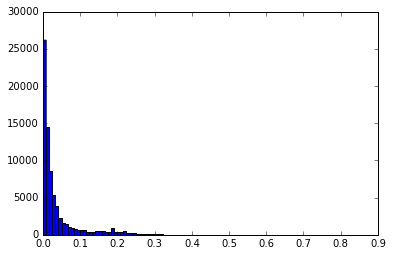

In [61]:
plt.hist(newpreds,bins=100);

In [25]:
test['var15'].unique()

array([ 32,  35,  23,  24,  43,  39,  29,  53,  37,  27,  40,  25,  52,
        57,  50,  41,  45,  38,  31,  28,  30,  26,  88,  36,  42,  58,
        61,  22,  48,  64,  49,  81,  33,  54,  51,  44,  56,  46,  67,
        34,  60,  74,  65,  73,  62,  69,  47,  63,  92,  71,  59,  55,
        19,  80,  72,  82,  77,  75,  91,  84,  70, 105,  86,  11,  20,
        13,  83,   5,  66,  85,  68,  12,  90,  78,  94,  15,  79,  93,
        21,  76,   7,  95,  87,  89,  14,  96,  17,   6,   9,  10,  98,
         8, 104,  16, 103,  99,  97, 102,  18, 101])

In [17]:
from sklearn.linear_model import LogisticRegression

In [37]:
from sklearn.cross_validation import cross_val_score, StratifiedKFold

In [41]:
skf = StratifiedKFold(target, n_folds=3)

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
sc = StandardScaler()
train_sc = sc.fit_transform(train)

In [26]:
cross_val_score(LogisticRegression(), train_sc, target, scoring='roc_auc', cv=skf)

array([ 0.80190131,  0.80128459,  0.76915691,  0.80532112,  0.82085511,
        0.81229987,  0.79515959,  0.82708531,  0.80473132,  0.79433228])

In [ ]:
from sklearn

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
cross_val_score(RandomForestClassifier(n_estimators=500, max_depth=50, max_features=50, class_weight='balanced',
                                    random_state=42, n_jobs=-1), train, target, scoring='roc_auc', cv=skf)

array([ 0.77884987,  0.77405909,  0.79552642])

In [8]:
from tqdm import *

In [9]:
floatfeats = list()
binfeats = list()
catfeats = list()
for col in train.columns:
    if train[col].dtype == 'float64':
        floatfeats.append(col)
    elif train[col].dtype == 'int64' and len(train[col].unique()) == 2:
        #train.loc[:, col] = train.loc[:, col].astype('int16')
        binfeats.append(col)
    else:
        #train.loc[:, col] = train.loc[:, col].astype('int16')
        catfeats.append(col)
catfeats = catfeats[:-1]

In [10]:
ztrain = train.copy()
ztest = test.copy()

In [11]:
for c in catfeats:
    fct, ind = pd.factorize(ztrain[c])
    ztrain.loc[:, c] = fct
    ztest.loc[:, c] = ind.get_indexer(ztest[c])
ncatfeats = list()
for c in tqdm(catfeats):
    ntr = pd.get_dummies(ztrain[c], prefix=c+'@')
    nts = pd.get_dummies(ztest[c], prefix=c+'@')
    ztrain = pd.concat((ztrain, ntr), axis=1)
    ztest = pd.concat((ztest, nts.loc[:, ntr.columns]), axis=1)
    for t in ntr.columns:
        ncatfeats.append(t)

100%|██████████| 91/91 [01:30<00:00,  1.86s/it]


In [12]:
import gc
del(train)
del(test)
#del(ztest)
gc.collect()

2519

In [13]:
dtrainz = xgb.DMatrix(ztrain[floatfeats + binfeats + ncatfeats + ['n0']], target)

In [14]:
res = xgb.cv(params, dtrainz, num_boost_round=2000, nfold=5, verbose_eval=True,
             stratified=True, maximize=True, early_stopping_rounds=200)

Will train until cv error hasn't decreased in 200 rounds.
[0]	cv-test-auc:0.748197+0.016095503508744308	cv-train-auc:0.7531116000000001+0.01844702286657659
[1]	cv-test-auc:0.7787872+0.007395336919978665	cv-train-auc:0.7860338+0.012787255442822743
[2]	cv-test-auc:0.7861248+0.007607194552527228	cv-train-auc:0.7927684000000002+0.00917830281914908
[3]	cv-test-auc:0.7928078+0.007048504845710192	cv-train-auc:0.8019388000000001+0.004931804432456752
[4]	cv-test-auc:0.7899676+0.006276624908340451	cv-train-auc:0.8008266+0.004299843792511518
[5]	cv-test-auc:0.7902916+0.00883948748740559	cv-train-auc:0.802566+0.00452931151500976
[6]	cv-test-auc:0.7918206000000001+0.006752661833677157	cv-train-auc:0.8056976+0.008009538977993651
[7]	cv-test-auc:0.7928008+0.007337358064044578	cv-train-auc:0.8069632+0.007108810094523546
[8]	cv-test-auc:0.7925896+0.008273271701086582	cv-train-auc:0.8073714000000001+0.004465222260985467
[9]	cv-test-auc:0.7939309999999999+0.008721265435703694	cv-train-auc:0.8095650000000

In [15]:
dtestz = xgb.DMatrix(ztest[floatfeats + binfeats + ncatfeats + ['n0']])

In [18]:
gbm = xgb.train(params, dtrainz, num_boost_round=600, verbose_eval=False)
preds = gbm.predict(dtestz)

In [19]:
sample = pd.read_csv('data/sample_submission.csv', index_col='ID')
sample.TARGET = preds
sample.to_csv('submission/init_xgb_cl_ohe.csv', index_label='ID')

In [5]:
dlist = list()
for c in train.columns:
    if train[c].unique().shape[0] == 1:
        print(c)
        dlist.append(c)
train.drop(dlist, axis=1, inplace=True)
test.drop(dlist, axis=1, inplace=True)

ind_var2_0
ind_var2
ind_var27_0
ind_var28_0
ind_var28
ind_var27
ind_var41
ind_var46_0
ind_var46
num_var27_0
num_var28_0
num_var28
num_var27
num_var41
num_var46_0
num_var46
saldo_var28
saldo_var27
saldo_var41
saldo_var46
imp_amort_var18_hace3
imp_amort_var34_hace3
imp_reemb_var13_hace3
imp_reemb_var33_hace3
imp_trasp_var17_out_hace3
imp_trasp_var33_out_hace3
num_var2_0_ult1
num_var2_ult1
num_reemb_var13_hace3
num_reemb_var33_hace3
num_trasp_var17_out_hace3
num_trasp_var33_out_hace3
saldo_var2_ult1
saldo_medio_var13_medio_hace3


In [6]:
for cone in train.columns:
    for ctwo in train.columns:
        if cone not in train.columns:
            continue
        if ctwo not in train.columns:
            continue
        if cone != ctwo and np.all(train[cone] == train[ctwo]):
            print(cone, ctwo)
            train.drop(ctwo, axis=1, inplace=True)
            test.drop(ctwo, axis=1, inplace=True)

ind_var6_0 ind_var29_0
ind_var6 ind_var29
ind_var13_medio_0 ind_var13_medio
ind_var18_0 ind_var18
ind_var26_0 ind_var26
ind_var25_0 ind_var25
ind_var32_0 ind_var32
ind_var34_0 ind_var34
ind_var37_0 ind_var37
ind_var40 ind_var39
num_var6_0 num_var29_0
num_var6 num_var29
num_var13_medio_0 num_var13_medio
num_var18_0 num_var18
num_var26_0 num_var26
num_var25_0 num_var25
num_var32_0 num_var32
num_var34_0 num_var34
num_var37_0 num_var37
num_var40 num_var39
saldo_var6 saldo_var29
saldo_var13_medio saldo_medio_var13_medio_ult1
delta_imp_reemb_var13_1y3 delta_num_reemb_var13_1y3
delta_imp_reemb_var17_1y3 delta_num_reemb_var17_1y3
delta_imp_reemb_var33_1y3 delta_num_reemb_var33_1y3
delta_imp_trasp_var17_in_1y3 delta_num_trasp_var17_in_1y3
delta_imp_trasp_var17_out_1y3 delta_num_trasp_var17_out_1y3
delta_imp_trasp_var33_in_1y3 delta_num_trasp_var33_in_1y3
delta_imp_trasp_var33_out_1y3 delta_num_trasp_var33_out_1y3


In [7]:
for c in train.columns:
    cmin = train[c].min()
    cmax = train[c].max()
    test.loc[test[c] < cmin, c] = cmin
    test.loc[test[c] > cmax, c] = cmax

In [8]:
import xgboost as xgb

In [9]:
weights = np.ones(target.shape)

In [10]:
weights[target == 1] = target.shape[0] / target.sum()

In [11]:
dtrain = xgb.DMatrix(train, target, weight=weights)

In [12]:
params = {'objective': 'binary:logistic', 
          'eval_metric': 'auc',
          'eta': 0.0202048,
          'max_depth': 5,
          'subsample': 0.6815,
          'colsample_bytree': 0.701,
          'silent': 1,
          'seed': 0
}

In [13]:
xgb.cv(params, dtrain, num_boost_round=560, nfold=5, stratified=True, verbose_eval=True)

[0]	cv-test-auc:0.7865172+0.044165035448417794	cv-train-auc:0.8044428+0.03280424928816386
[1]	cv-test-auc:0.8040001999999999+0.028295485119714768	cv-train-auc:0.8204376+0.02360768277150469
[2]	cv-test-auc:0.8086548+0.026297593854951846	cv-train-auc:0.8261010000000001+0.02429910182702234
[3]	cv-test-auc:0.8125432+0.02845345634821895	cv-train-auc:0.8310210000000001+0.025118148251811873
[4]	cv-test-auc:0.8144852+0.02884715273575539	cv-train-auc:0.8329912+0.024154725975676066
[5]	cv-test-auc:0.8142064+0.028763779199541897	cv-train-auc:0.833579+0.023589195492852235
[6]	cv-test-auc:0.822508+0.01649571498298876	cv-train-auc:0.840493+0.01313420439920136
[7]	cv-test-auc:0.8254085999999999+0.012323657129277818	cv-train-auc:0.8431198+0.00897294650379684
[8]	cv-test-auc:0.8281288+0.011194362373980925	cv-train-auc:0.8456954+0.006607541830363235
[9]	cv-test-auc:0.8297064000000001+0.010099125241326615	cv-train-auc:0.8470842+0.005487855624923109
[10]	cv-test-auc:0.829561+0.010846124137220643	cv-train-

KeyboardInterrupt: 

In [14]:
dtest = xgb.DMatrix(test)

In [15]:
gbm = xgb.train(params, dtrain, num_boost_round=256)

In [16]:
preds = gbm.predict(dtest)

In [17]:
preds

array([ 0.53241587,  0.61659712,  0.03572532, ...,  0.07458355,
        0.62134498,  0.02381196], dtype=float32)

In [18]:
sample = pd.read_csv('data/sample_submission.csv', index_col='ID')
sample.TARGET = preds
sample.to_csv('submission/init_xgb_w.csv', index_label='ID')